# Домашнее задание 2 (Линейная регрессия и KNN)

В каждом пункте от вас потребуется дописать код, необходимый для реализации задания, а так же ответить на ряд вопросов, проанализировав полученные результаты. Просьба отвечать на вопросы развёрнуто, аппелируя к полученным значениям или графикам, ответы вписывать в отдельную ячейку, выбрав для неё тип "Markdown". От полноты и качества ответов будет во многом зависеть ваша итоговая оценка.

Задание выполняется самостоятельно, плагиат будет стандартно наказываться лишением всех баллов за задание.

- Максимальная оценка за задание: 10 баллов.
- Дата выдачи: 28.2.2018
- Срок сдачи: 23:59 13.3.2018

In [1]:
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
%matplotlib inline

## Часть 1. Работа с модельными данными

В данном пункте требуется разобраться с базовыми техниками регрессионного анализа и сравнить их между собой на данных, чьи характеристики вы уже знаете (т.е., вам их придётся сгенерировать). Тем самым вы сами выявите все преимущества и недостатки используемых методов перед тем, как применять их на реальных данных, где полученные результаты, вообще говоря, без предварительных знаний могут плохо поддаваться объяснению.

Как вам уже известно из семинаров и лекций, существуют разные типы регрессии, которые определяют форму и свойства регрессионных кривых. Вы разберётесь с двумя основными способами их задания: трансформацией исходных данных $X$, а так же изменением оптимизируемого функционала $Q(w, b, \theta)$, где $w, b$ -- настраиваемые параметры линейной регрессии, $\theta$ -- т.н. гиперпараметры алгоритма построения регрессии, которые не настраиваются по обучающей выборке напрямую, поэтому всегда выделяются отдельно.

### 1.1. Генерация данных

От вас потребуется использовать уже знакомый по заданию 1 метод генерации данных для регрессии функций с линейным шумом:

In [2]:
def get_grid(n, D, x_min, x_max):
    """Генерирует сетку размера n^D x D"""
#    print('let`s make grid')
#    print(n, D, x_min, x_max)
    xn = np.linspace(x_min, x_max, n)
#    print('first step!')
#    print(xn)
#    print('now let`s see what the hell is this: ')
#    print(*([xn]*D))
    xn = np.meshgrid(*([xn]*D))
#    print('next step!')
#    print(xn)
#    print('next step!')
    return np.concatenate([xi.reshape((n**D, 1)) for xi in xn], axis=1)

def gen_data(n, D, x_min, x_max, f_target, f_noise):
    """Возвращает аргументы и зашумлённые значения для заданной функции
    
    Данная функция принимает на вход параметры выборки, которую требуется
    сгенерировать, а так же ссылки на функции, которые должны
    использоваться при генерации.
    
    n        -- размер одномерной выборки (совпадает с N при D=1)
    D        -- размерность выборки
    f_target -- целевая функция, которую будет аппроксимировать регрессия
    f_noise  -- функция, которая генерирует шум
    
    Возвращает сгенерированные данные и ответы на этих данных, а так же
    истинные значения функции
    
    X    -- выборка размера NxD, где N=n^D
    y    -- зашумлённые значения целевой функции
    y_gt -- истинные значения целевой функции"""
    X = get_grid(n, D, x_min, x_max)
#    print('the result of the first function is:')
#    print(X)
    N = X.shape[0]
#    print(N)
    y_gt = f_target(X)
#    print('here is the target function result:')
#    print(y_gt)
    y = y_gt + f_noise(N)
#    print('here is noise result: ')
#    print(y)
    return X, y, y_gt

Пример генерации выборки для одномерной линейной функции с шумом $y = 2x + 3 + \epsilon$, где $x$ -- детерминированная переменная, $\epsilon$ -- шум  из нормального распределения с параметрами $\mu = 2, \sigma^2 = 4$, обозначение: $\epsilon \sim \mathcal{N}(2, 4)$.

In [3]:
def f_target(X):
    return 2*X + 3

def f_noise(N):
    """Обратите внимание, что функция random.normal принимает на вход
    стандартное отклонение, т.е. корень из диспресии"""
    return np.random.normal(loc=2, scale=2, size=N).reshape((N, 1))

X, y, y_gt = gen_data(10, 1, 0, 10, f_target, f_noise)
#print(X)
#print('hey!')
#print(y)
#print('yay!')
#print(y_gt)

### 1.2. Знакомство с библиотеками

Для реализации регрессии вам потребуется пользоваться классами из библиотеки sklearn, в которой собраны практически все основные методы машинного обучения.

Базовым методом построения регрессии является линейная регрессия. Для её обучения предлагается использовать класс LinearRegression из модуля sklearn.linear_model

Оптимизируемый ей функционал записывается в следующем уже знакомом вам виде: $$ Q(w, b) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 \longrightarrow \min\limits_{w,b} $$

Описание класса: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

Так же вы познакомитесь с ещё двумя моделями регрессии: Ridge регрессия, которая призвана позволить регрессии работать лучше в случае, когда в признаках присутствовует линейная зависимость, и регрессия Lasso, которая дополнительно осуществляет отбор более информативных с её точки зрения признаков.

Функционал для Ridge регрессии:

$$ Q(w, b, \alpha) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 + \frac{1}{\alpha} \sum_{d=1}^D w_d^2  \longrightarrow \min\limits_{w,b} $$

Как видно, выбор оптимальных $w$ и $b$ будет существенно зависеть от выбора $\alpha$, но при этом сам параметр $\alpha$ в задаче оптимизации, решаемой по обучающей выборке, не участвует и участвовать не может, поэтому называется гиперпараметром данной модели.

Это означает, что Ridge регрессия (как и регрессия Lasso) уже не является решением out of the box, у самого алгоритма присутствуют так называемый гиперпараметр, от выбора которого напрямую будет зависеть качество решения вашей задачи. Такая ситуация крайне типична для машинного обучения. Для настройки параметров существует несколько подходов, и вы с ними познакомитесь позже. Пока что вам предлагается пользоваться регрессиями с параметрами по умолчанию.

Функционал для регрессии Lasso:

$$ Q(w, b, \alpha) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 + \frac{1}{\alpha} \sum_{d=1}^D |w_d|  \longrightarrow \min\limits_{w,b} $$

Описание класса Ridge: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

Описание класса Lasso: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Ещё при построении регрессионных кривых сложного вида широко используется механизм трансформации признаков, когда вы некоторым способом делаете преобразование вашей выборки, генерируя по ней новую матрицу признаков размера NxD', где D' > D, и уже на новой выборке обучаете линейную регрессию.

Например, если в исходной матрице у вас всего два признака a и b, то, преобразовав их в [1, a, b, a^2, ab, b^2], вы сможете, применяя линейную регрессию на новых признаках, получать регрессионные кривые второго порядка.

Эти преобразования для любой степени итогового полинома выполняет класс PolynomialFeatures.

Описание класса: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn-preprocessing-polynomialfeatures

### 1.3. Эксперименты

Т.к. эксперименты мы будем проводить на искусственных данных, то для них мы всегда знаем значения незашумлённой функции, поэтому качество работы методов будем оценивать следующим функционалом усреднённой ошибки: $$\text{err}\ (y_{pred}, y_{gt}) = \frac{1}{N} \sum_{n=1}^N (y_{pred} - y_{gt})^2 $$ где $y_{pred}$ -- значения, предсказанные регрессией, $y_{gt}$ -- истинные значения функции (gt здесь сокращение от groundtruth, т.е. истинная незашумлённая функция).

#### Эксперимент 1

Сгенерируйте зашумлённую выборку для функции $y = x + \epsilon$, где $x$ принимает значения из равномерной сетки на [0, 3], а $\epsilon \sim \mathcal{N}(0, 1)$. Постройте график зависимости ошибки вашей линейной регрессии от размера выборки. При каком размере выборки регрессионная прямая перестаёт быть визуально отличимой от истинной? Постройте график с истинной прямой и обученной посредством регрессии.

Пример вызова класса, выполняющего линейную регрессию:

    LR = lm.LinearRegression()
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_train)

In [4]:
def f_target(X):
    return X 

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

N_grid = list(range(10, 1000, 10)) # список N, для которых требуется провести эксперимент

#X, y, y_gt = gen_data(N_grid[70], 1, 0, 3, f_target, f_noise) # Сгенерированные данные
#----------------------------------------------------------------------------
#plt.scatter(X, y)
def graphic(n):
#    print(edge)
    X, y, y_gt = gen_data(N_grid[n], 1, 0, 3, f_target, f_noise)
    edge=-(len(X)//4)
    x_train, x_test=X[:edge], X[edge:]
    y_train, y_test=y[:edge], y[edge:]
    plt.scatter(x_train, y_train)
    plt.scatter(X, y_gt, color='green')
    LR=lm.LinearRegression()
    LR.fit(x_train, y_train)
    y_pred=LR.predict(x_test)
    plt.scatter(x_test, y_test, color='yellow')
    plt.plot(x_test, y_pred, color = 'red')
    return y_pred, y_test, LR
#    return LR
#graphic(5)
#plt.plot(f_noise(X), LR.predict(f_noise(X)), color = 'red')

Для каждого N в цикле добавьте в список err ошибку регрессии, которую вы обучили на случайных N элементах датасета. Ошибку требуется считать как MSE. Так же для каждого N сохраните обученные классы регрессии в список LRs (в примере вызова класс назван LR). predict делайте на всей выборке X.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
[ 0.91420878  1.81591727  0.41924454  1.31719277  1.49654177  1.01123097
  1.07591892  2.1077749   1.25445098  0.98075126  0.608411    0.77498254
  1.32114107  1.14047832  1.49902167  0.83801594  1.2125832   1.04892294
  0.74368998  0.93539046  1.13824273  0.96330658  0.92779637  0.91531379
  1.14144698  1.13195639  1.15807314  0.80303547  1.16245991  1.14891965
  0.75031657  1.06334521  0.87362137  0.93352363  0.80494995  0.88752839
  0.88854733  0.7321222   1.36361772  1.04140819  0.94672927  0.8163937
  0.75902822  1.02997778  0.80302713  1.15793971  1.02692071  1.13998105
  1.02891113  0.95396029  0.90530114  0.89975038  1.06610127  0.85646376
  0.99036736  0.82861382  0.83514637  1.06086645  0.97125

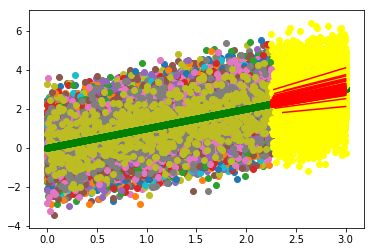

In [5]:
#LR=lm.LinearRegression()
#LR.fit(X, y)
#y_pred=LR.predict(X)
err = []
LRs = []
#LRs=[x[0] for x in y_pred]
for N in range(len(N_grid)):
    print(N)
    X, y, y_gt = gen_data(N, 1, 0, 3, f_target, f_noise)
    r=graphic(N)
#    print(r)
    mse=np.mean((r[0]-r[1])**2)
    err.append(mse)
    LRs.append(r[2])
#print(err)
#print(N_grid)
#plt.plot(N_grid, err)
#a=min(err)
#b=max(err)
#print(a, b)
err=np.array(err)
print(err)
#    err.append(*(y_pred[N-1]-y_gt[N-1])**2)
    
#    pass # Place your code here
#for x in X:
#    print(LR.predict(x))
#    print(f_noise(N_grid[-1]))
#    se=(LR.predict(x)-f_noise(N_grid[-1])[x])**2
#    print(se)
#    err.append(se)

Код для построения графиков:

[ 0.91420878  1.81591727  0.41924454  1.31719277  1.49654177  1.01123097
  1.07591892  2.1077749   1.25445098  0.98075126  0.608411    0.77498254
  1.32114107  1.14047832  1.49902167  0.83801594  1.2125832   1.04892294
  0.74368998  0.93539046  1.13824273  0.96330658  0.92779637  0.91531379
  1.14144698  1.13195639  1.15807314  0.80303547  1.16245991  1.14891965
  0.75031657  1.06334521  0.87362137  0.93352363  0.80494995  0.88752839
  0.88854733  0.7321222   1.36361772  1.04140819  0.94672927  0.8163937
  0.75902822  1.02997778  0.80302713  1.15793971  1.02692071  1.13998105
  1.02891113  0.95396029  0.90530114  0.89975038  1.06610127  0.85646376
  0.99036736  0.82861382  0.83514637  1.06086645  0.97125598  1.26263511
  0.89445107  0.77727993  0.94166471  0.93672504  1.19031367  1.07609979
  0.92006986  0.92089818  0.90401326  0.86612808  1.04909188  0.90364931
  1.03683516  1.17629523  1.10840694  1.11185656  1.07117308  1.0211535
  0.91821827  1.09957598  0.8902041   1.07677438  0.9

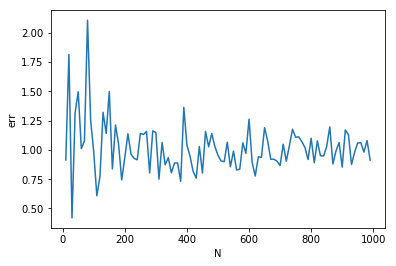

In [6]:
print(err)
#print(np.max(err))
#print(np.argmax(err))
plt.plot(range(10, 1000, 10), err)
#plt.scatter(np.argmin(err[9:])*10+100, np.min(err[9:]), color='red')
plt.xlabel("N")
plt.ylabel("err")
#print(np.argmin(err[9:]), np.min(err[9:]))
plt.show()

99 99
2
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


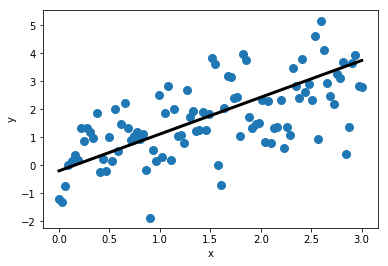

In [7]:
#plt.scatter(X, y, c="black", alpha=0.1)
plt.scatter(X, y, linewidth=3)
print(len(LRs), len(err))
t=LRs[np.argmin(err)]
print(np.argmin(err))
print(t)
y_pred = LRs[np.argmin(err)].predict(X) #y_pred = a.predict(X)
plt.plot(X, y_pred, linewidth=3, color='black')
#plt.legend(["Groundtruth", "LR"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Проделайте тоже самое для KNN при n_neighbors=3.

In [9]:
##err = []
##KNNs = []
##X, y, y_gt = gen_data(N_grid[1], 1, 0, 3, f_target, f_noise)
#from sklearn import neighbors
#for weights in ['uniform', 'distance']:
#    # we create an instance of Neighbours Classifier and fit the data.
#    clf = neighbors.KNeighborsClassifier(3, weights=weights)
#    clf.fit(X, y)
#print(X)
##newx=X.reshape(len(X), 1)
#print(newx)
#print(y)
#newy=y.reshape(len(y), 1)
#print(newy)
##edge=-(len(newx)//4)
##newy=y.reshape(len(y), 1)
##x_train, x_test=newx[:edge], newx[edge:]
##y_train, y_test=newy[:edge], newy[edge:]
#print('here is x_train')
#print(x_train)
#print('here is y_train')
#print(y_train)
#print(x_train.shape(), y_train.shape())
##from sklearn.neighbors import KNeighborsClassifier as skn
#knn = KNeighborsClassifier(n_neighbors=3)
#print('now you see lens')
#print(len(x_train), len(y_train))
#knn.fit(np.array(x_train), np.array(y_train)) 
#pred=knn.predict(x_test)
##neigh = skn.NearestNeighbors(n_neighbors=3).fit(X)
##dictances, indices = neigh.kneighbors(X)
##print (accuracy_score(y_test, pred))
#for N in N_grid:
#    pass # Place your code here

0
0.549478401961
1
1.18330944963
2
0.570521534365
3
0.547631813406
4
0.467877329476
5
0.533191475206
6
0.599221528927
7
0.517543334039
8
0.604267664679
9
0.586227407498
10
0.516575270721
11
0.608820725106
12
0.596927506352
13
0.957079219897
14
0.558893462623
15
0.712207052253
16
0.539017276868
17
0.606147881131
18
0.685872176314
19
0.616746319999
20
0.549168263664
21
0.694712508286
22
0.769693709725
23
0.600571589878
24
0.622454799857
25
0.546639506191
26
0.772150353435
27
0.681442873081
28
0.679949819705
29
0.546162502009
30
0.67244007432
31
0.748260977906
32
0.726696221185
33
0.645098396197
34
0.6561789686
35
0.618655938914
36
0.715776543579
37
0.72370204761
38
0.575627198075
39
0.804012966525
40
0.756524569998
41
0.672116230524
42
0.665851304369
43
0.647978547017
44
0.643385271046
45
0.768242959037
46
0.678737166111
47
0.743508698821
48
0.702380992459
49
0.554739431322
50
0.627776857414
51
0.694549566488
52
0.674108390259
53
0.612752643928
54
0.660728759012
55
0.688634823141
56
0.63

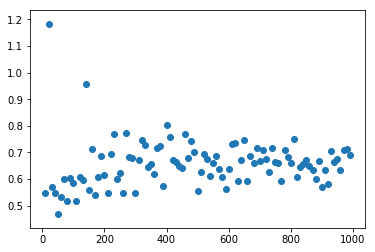

In [10]:
from sklearn.neighbors import KNeighborsRegressor
def kNNgraphic(n):
    X, y, y_gt = gen_data(N_grid[n], 1, 0, 3, f_target, f_noise)
#edge=-(len(X)//4)
#x_train, x_test=X[:edge], X[edge:]
#y_train, y_test=y[:edge], y[edge:]
#    plt.scatter(X, y)
#    plt.scatter(X, y_gt, color='green')
#from sklearn.neighbors import KNeighborsClassifier
#knn = KNeighborsClassifier(n_neighbors=3)
#knn.fit(np.array(x_train), np.array(y_train)) 
#pred=knn.predict(x_test)
#import sklearn.neighbors
#from sklearn.neighbors import KNeighborsRegressor
    neigh = KNeighborsRegressor(n_neighbors=3)
    neigh.fit(X, y) 
#print(x_test)
    pred=neigh.predict(X)
#print(pred)
#    plt.plot(X, pred, color='red')
    mse=np.mean((pred-y)**2)
    return mse, neigh
#print(mse)
#from sklearn.metrics import log_loss
#np.reshape(y,410)
#y=[y]
#print(y)
#y=[float(a) for a in y]
#pred.shape(pred,1)
#print(y)
#print(len(y), len(pred))
#err=log_loss(y, pred)
#err = - (y * np.log(pred) + (1 - y) * np.log(1 - pred))
#print(err)
N_grid = list(range(10, 1000, 10))
kNN_err=[]
kNNs=[]
for N in range(len(N_grid)):
    r=kNNgraphic(N)
    print(N)
    print(r[0])
    kNN_err.append(r[0])
    kNNs.append(r[1])
print(len(kNN_err))
plt.scatter(N_grid, kNN_err)

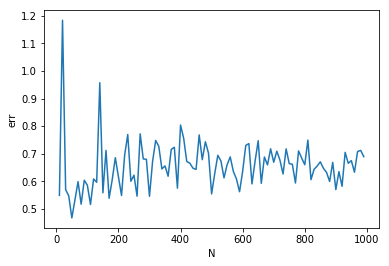

In [11]:
plt.plot(range(10, 1000, 10), kNN_err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

4
99
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=3, p=2,
          weights='uniform')


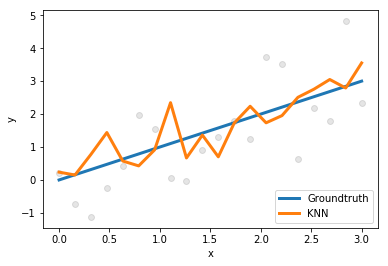

In [12]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
print(np.argmin(kNN_err))
print(len(kNNs))
print(kNNs[np.argmin(kNN_err)])
y_pred = kNNs[np.argmin(kNN_err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "KNN"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Увеличте число соседей до 10 и проделайте тоже самое.

[ 1.63308676  1.00917567  0.94626863  0.77029479  1.03598906  1.08406038
  1.03221545  0.78675628  0.74430518  0.92383156  0.81694133  0.8394152
  1.03191376  0.7466048   0.90348436  0.69589395  0.89401291  0.80052964
  0.92943436  0.91450939  0.95604259  0.81917031  0.8440238   0.95278079
  0.83531549  0.84266738  0.87856728  0.85937123  0.75429334  0.95696752
  0.8294311   0.94967222  0.88870913  1.01076576  0.9233439   0.79461515
  0.93713829  0.82225831  0.9187985   0.81978144  0.9871158   0.82327599
  1.0004065   0.78602275  0.91205058  0.99171982  0.92039662  0.88145029
  0.83843508  0.90850276  0.9621556   0.92031431  0.82475071  0.98103244
  0.80799557  0.81755989  0.96383427  0.86163108  0.91960833  0.82619341
  0.91951091  0.95437695  0.82831693  0.8860651   0.96801661  0.94603042
  0.84424972  0.93619324  0.88166389  0.83188939  0.88405138  0.9890455
  0.88462595  0.89742304  0.91990821  0.92675451  0.97563213  0.91842575
  0.89544128  0.88890453  0.86901668  0.79109144  0.9

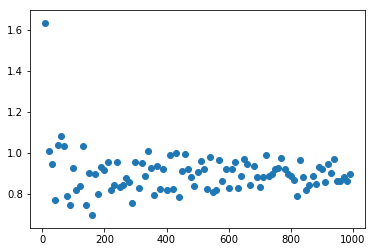

In [14]:
err = []
KNNs = []
def kNN_10_graphic(n):
    X, y, y_gt = gen_data(N_grid[n], 1, 0, 3, f_target, f_noise)
    neigh = KNeighborsRegressor(n_neighbors=10)
    neigh.fit(X, y) 
#print(x_test)
    pred=neigh.predict(X)
#print(pred)
#    plt.plot(X, pred, color='red')
    mse=np.mean((pred-y)**2)
    return mse, neigh
N_grid = list(range(10, 1000, 10))
kNN_10_err=[]
kNNs_10=[]
for N in range(len(N_grid)):
    r=kNN_10_graphic(N)
#    print(N)
#    print(r[0])
    kNN_10_err.append(r[0])
    kNNs_10.append(r[1])
kNN_10_err=np.array(kNN_10_err)
print(kNN_10_err)
print(len(kNN_10_err), len(N_grid))
plt.scatter(N_grid, kNN_10_err)

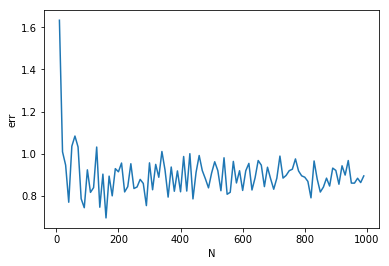

In [15]:
plt.plot(range(10, 1000, 10), kNN_10_err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

15


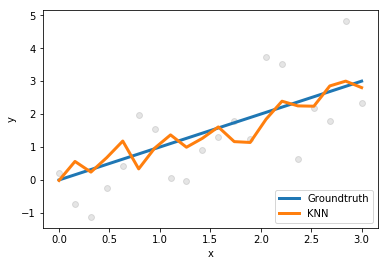

In [16]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
a=np.argmin(kNN_10_err)
print(a)
y_pred = kNNs_10[np.argmin(kNN_10_err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "KNN"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Какие выводы можно сделать?

1. чем больше выборка объектов, тем лучше получаются результаты как для обычной линейной регрессии, так и для kNN
2. чем больше количество соседей, тем лучше получаются результаты для kNN
3. при этом среднеквадратичная ошибка при kNN=2 колеблется в меньшем диапазоне, чем среднеквадратичная ошибка обычной линейной регрессии и kNN=10

## Эксперимент 2

Изучим поведение регрессии с полиномиальными признаками. Для этого будем использовать класс PolynomialFeatures. Код вызова выглядит примерно так:

        import sklearn.preprocessing as pp
        pp.PolynomialFeatures(degree=d_new)
        X_new = pp.fit_transform(X)

Сгенерируйте выборку для $y = log \frac{1}{3} x + \epsilon$, где $x$ принимает значения из равномерной сетки на  [1, 10], $\epsilon \sim \mathcal{N}(0, 1)$. Рассмотрите три случая: линейный, полиномиальные признаки степени 2 и 5. Для каждого постройте графики, аналогичные графику из эксперимента 1 и сравните их. Какой эффект вы наблюдаете? По какой причине он возникакет? Постройте график истинной кривой, и наилучших среди полиномиальных, которые вы исследовали. Какая из них лучше всего приближает данные и почему?

In [17]:
import sklearn.preprocessing as pp
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model as lm
scaler = StandardScaler()
from sklearn.naive_bayes import GaussianNB
#from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
def f_target(X):
    return np.log(0.3*X)

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

N_grid = np.arange(10, 1000, 10)


Аналогично предыдущему пункту, обучите в трёх циклах три разные регрессии, сохраняя полученные ошибки и классы в списки err_i и LRs_i. Перед обучением второй и третьих моделей вам требуется преобразовать признаки в полиномиальные, используя указанный в примере класс PolynomialFeatures. Сохраните полученные признаки степени 2 в переменную X_new_2, а признаки степени 5 в переменную X_new_3. Обучение соответственно происходит на выборках (X, y), (X_new_2, y), (X_new_3, y).

(array([[-1.2039728 ],
        [-1.16181199],
        [-1.12135704],
        [-1.08247525],
        [-1.04504885],
        [-1.00897279],
        [-0.97415302],
        [-0.94050499],
        [-0.90795239],
        [-0.87642613],
        [-0.84586348],
        [-0.81620727],
        [-0.78740528],
        [-0.75940967],
        [-0.73217652],
        [-0.7056654 ],
        [-0.679839  ],
        [-0.65466284],
        [-0.63010499],
        [-0.6061358 ],
        [-0.58272771],
        [-0.55985505],
        [-0.53749387],
        [-0.5156218 ],
        [-0.49421789],
        [-0.47326252],
        [-0.45273729],
        [-0.43262488],
        [-0.41290901],
        [-0.39357436],
        [-0.37460646],
        [-0.35599165],
        [-0.33771703],
        [-0.31977039],
        [-0.30214016],
        [-0.28481537],
        [-0.26778563],
        [-0.25104105],
        [-0.23457225],
        [-0.21837027],
        [-0.20242662],
        [-0.18673319],
        [-0.17128224],
        [-0

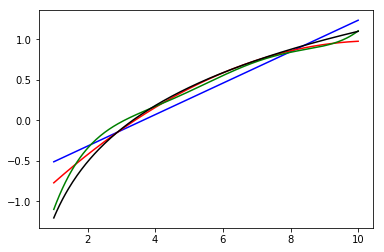

In [33]:
def graphic2(n):
    X, y, y_gt = gen_data(N_grid[n], 1, 1, 10, f_target, f_noise)
    LR = lm.LinearRegression()
    colors=['red', 'green']
    linreg=LR.fit(X, y)
    y_pred=linreg.predict(X)
    plt.plot(X, y_pred, color='blue')
    models=[]
    y_fits=[]
    X_news=[]
    for number, degree in enumerate([2, 5]):
        poly=pp.PolynomialFeatures(degree=degree)
#print(X)
#print()
#model = make_pipeline(pp.PolynomialFeatures(2), lm.Ridge())
        X_new=poly.fit_transform(X)
        X_news.append(X_new)
#print(X_new)
        regr=LR.fit(X_new, y)
        models.append(regr)
#print(regr)
#print(X.shape, y.shape, X_new.shape)
        y_quad_fit=LR.predict(X_new)
        y_fits.append(y_quad_fit)
#plt.plot()
        plt.plot(X, y_quad_fit, color=colors[number])
    plt.plot(X, y_gt, color='black')
    return(y_gt, y_pred, y_fits[0], y_fits[1], linreg, models[0], models[1], X, X_news[0], X_news[1])
graphic2(20)
#model = make_pipeline(poly)
#y_plot = model.predict(X)
#plt.plot(X_new, y_plot, color='red', linewidth=2)

Исходя из графика на выборке в 210 точек, можно судить, что регрессии с полиномиальными признаками значительно больше приближают значения реальной выборки, чем с линейными. Это связано с тем, что регрессии с полиномиальными признаками обучаются не на векторе данных, а на матрице, включающей в себя полиномиальное разложение.

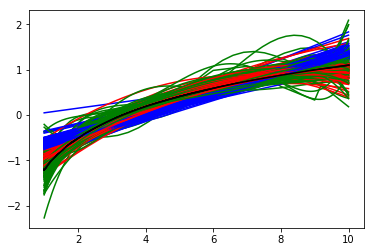

In [35]:
from sklearn.metrics import mean_squared_error
err_1 = []
LRs_1 = []
#for N in N_grid:
#for N in range(len(N_grid)):
    
#    pass # Place your code here

err_2 = []
LRs_2 = []
pass # Преобразуйте признаки в полиномиальные степени 2
#for N in N_grid:
#    pass # Place your code here

err_3 = []
LRs_3 = []
N_grid = list(range(10, 1000, 10))
X_1_all=[]
X_2_all=[]
X_3_all=[]
#print(N_grid)
#print(len(N_grid))
for n in range(len(N_grid)):
    g=graphic2(n)
    err1=mean_squared_error(g[0], g[1])
    err2=mean_squared_error(g[0], g[2])
    err3=mean_squared_error(g[0], g[3])
    LR1=g[4]
    LR2=g[5]
    LR3=g[6]
    X_new=g[7]
    X_new_2=g[8]
    X_new_3=g[9]
    err_1.append(err1)
    err_2.append(err2)
    err_3.append(err3)
    LRs_1.append(LR1)
    LRs_2.append(LR2)
    LRs_3.append(LR3)
    X_1_all.append(X_new)
    X_2_all.append(X_new_2)
    X_3_all.append(X_new_3)
#pass # Преобразуйте признаки в полиномиальные степени 5
#for N in N_grid:
#for n in range(len(N_grid)):
#    print(N)
#    X, y, y_gt = gen_data(N, 1, 0, 3, f_target, f_noise)
#    r=graphic2(N)
#   print(r[5])
#    mse_1=np.mean((r[1]-r[0])**2)
#    err_1.append(mse_1)
#    LRs_1.append(r[4])
#    mse_2=np.mean((r[2]-r[0])**2)
#    err_2.append(mse_2)
#    LRs_2.append(r[5])
#    mse_3=np.mean((r[3]-r[0])**2)
#    err_3.append(mse_3)
#    LRs_3.append(r[6])
#print(LRs_3)
err_1=np.array(err_1)
err_2=np.array(err_2)
err_3=np.array(err_3)
N_grid=np.array(N_grid)
#print(err_1)
#print(err_2)
#print(err_3)
#print(err_3)
#    LRs.append(r[2])
#return 'all!'
#print(err_3)
#    pass # Place your code here

Код для построения всех графиков:

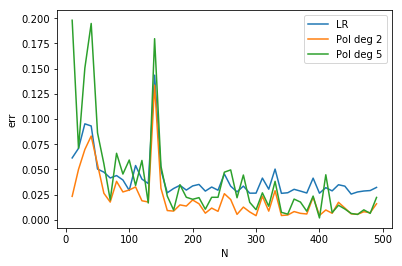

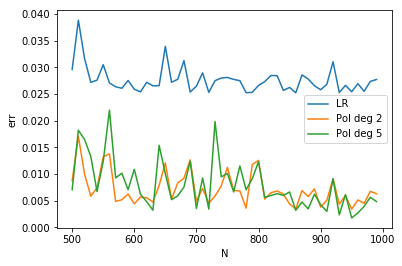

In [36]:
plt.plot(N_grid[:N_grid.size//2], err_1[:N_grid.size//2])
plt.plot(N_grid[:N_grid.size//2], err_2[:N_grid.size//2])
plt.plot(N_grid[:N_grid.size//2], err_3[:N_grid.size//2])
plt.legend(["LR", "Pol deg 2", "Pol deg 5"])
plt.xlabel("N")
plt.ylabel("err")
plt.show()

plt.plot(N_grid[N_grid.size//2:], err_1[N_grid.size//2:])
plt.plot(N_grid[N_grid.size//2:], err_2[N_grid.size//2:])
plt.plot(N_grid[N_grid.size//2:], err_3[N_grid.size//2:])
plt.legend(["LR", "Pol deg 2", "Pol deg 5"])
plt.xlabel("N")
plt.ylabel("err")
plt.show()

99 99
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


ValueError: shapes (950,3) and (6,1) not aligned: 3 (dim 1) != 6 (dim 0)

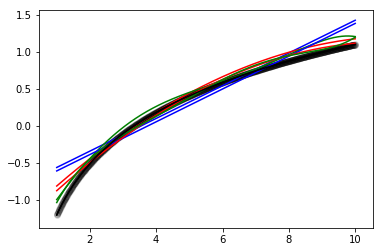

In [49]:
#err_2=np.array(err_2)
#print(err_2)
#err_3=np.array(err_3)
#graphic2(20)
#print(X_new)
X, y_gt=graphic2(98)[7], graphic2(98)[0]
plt.scatter(X, y_gt, c="black", alpha=0.1)
#plt.plot(X, y_gt, linewidth=3, color='black')
print(len(LRs_1), len(err_1))
print(LRs_1[np.argmin(err_1)])
#y_pred_1 = LRs_1[np.argmin(err_1)].predict(X)
#plt.plot(X, y_pred, linewidth=3, color='blue')
#print(np.argmin(err_3))
y_pred_2 = LRs_2[np.argmin(err_2)].predict(X_2_all[np.argmin(err_2)])
#plt.plot(X, y_pred_2, linewidth=3, color='green')
plt.plot(X_2_all[np.argmin(err_2)][:,0], y_pred_2, linewidth=3, color='green')
y_pred_3 = LRs_3[np.argmin(err_3)].predict(X_3_all[np.argmin(err_3)])
plt.plot(X, y_pred_3, linewidth = 3, color='red')
plt.legend(["Groundtruth", "LR", "Pol deg 2", "Pol deg 5"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

лучше всего приближает данные регрессия с признаками 5 степени.

#### Эксперимент 3

Рассмотрим данные с искусственно внесёнными в них линейными зависимостями. Для наглядности рассмотрим регрессию, которая фактически зависит лишь от одной переменной, но в сгенерированный набор данных внесём ещё несколько признаков, которые будут слабо коррелировать с первым.

Сгенерируйте зашумлённую выборку для функции $y = x + \epsilon$, $x$ принимает значения из равномерной сетки на [0, 3], $\epsilon \sim \mathcal{N}(0, 1)$. Добавьте в качестве второго признака $x_2 = 2x + \delta$, где $\delta \sim \mathcal{N}(0, 0.01)$, а в качестве третьего $x_3 = x_1 + x_2 + \nu$, где $\nu \sim \mathcal{N}(0, 0.25)$. Постройте графики истинной функции, линейной регрессии и Ridge регрессии, в зависимости от первого столбца данных (при этом саму регрессию нужно обучать по всем трём признакам). Какой эффект вы наблюдаете? Какая регрессия работает лучше и почему? (Для ответа на этот вопрос можете, например, сравнить веса признаков, полученные в случае обычной и Ridge линейных регрессий, параметр класса: coef_)

Пример вызова класса, выполняющего Ridge регрессию:

    Ridge = lm.Ridge()
    Ridge.fit(X_train, y_train)
    y_pred = LR.predict(X_train)

In [60]:
def f_target(X):
    return X

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

"""Генерация данных"""
N = 1000
X, y, y_gt = gen_data(N, 1, 0, 3, f_target, f_noise)
delta = np.random.normal(loc=0, scale=0.1, size=N).reshape((N, 1))
nu = np.random.normal(loc=0, scale=0.5, size=N).reshape((N, 1))
x2 = 2*X + delta
x3 = X + x2 + nu
X = np.concatenate([X, x2, x3], axis=1)
#print(X)
#print(len(X))
X_train, X_test = np.array_split(X, 2)
y_train, y_test =np.array_split(y, 2)
#print(X_train.shape, X_test.shape)
#print(y_train.shape, y_test.shape)

Аналогично предыдущим пунктам, обучите обычную и Ridge линейные регрессии на выборке (X, y) и получите предсказания для той и другой модели. Сохраните предсказания в переменные y_pred_LR и y_pred_Ridge.

In [61]:
#Pass # Place your code here
import sklearn.linear_model as lm
LR=lm.LinearRegression()

LR.fit(X_train, y_train)
y_pred_LR=LR.predict(X_test)
Ridge = lm.Ridge(alpha=0.1)
#print(len(y))
Ridge.fit(X_train, y_train)
y_pred_Ridge = Ridge.predict(X_test)

#plt.scatter([a for a in range(len(X_test))], y_test, color='green')
#plt.plot([i for i in range(len(X_test))], y_pred_LR, color='black')
#plt.plot([i for i in range(len(X_test))], y_pred_Ridge, color='red')

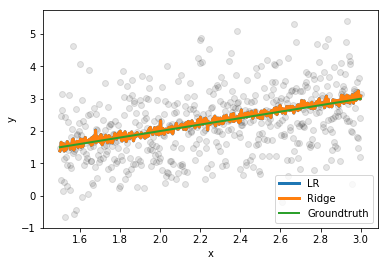

In [62]:
plt.scatter(X_test[:,0], y_test, c="black", alpha=0.1)
plt.plot(X_test[:,0], y_pred_LR, linewidth=3)
plt.plot(X_test[:,0], y_pred_Ridge, linewidth=3)
plt.plot(X_test[:,0], y_gt[500:], linewidth=2)
plt.legend(["LR", "Ridge", "Groundtruth"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

График для разности предсказанных ответов и истинных:

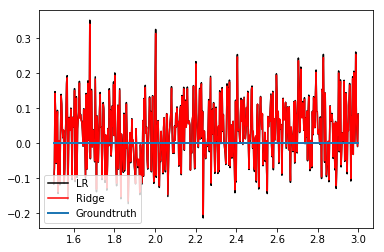

In [63]:
#print(N)
N=[n for n in range(N)]
#print(N)
plt.plot(X_test[:,0], y_pred_LR - y_gt[500:], color='black')
plt.plot(X_test[:,0], y_pred_Ridge - y_gt[500:], color='red')
plt.plot(X_test[:,0], np.zeros(len(N[500:])), linewidth=2)
#plt.plot(X_test[:,0], y_gt[500:], linewidth=2)
plt.legend(["LR", "Ridge", "Groundtruth"], loc=3)
plt.show()

In [65]:
print(np.sum((y_pred_LR - y_gt[500:])**2))
print(np.sum((y_pred_Ridge - y_gt[500:])**2))

4.30048069647
4.04991040898


In [66]:
print(LR.coef_)
print(Ridge.coef_)

[[-0.45330701  0.84844691 -0.07662373]]
[[-0.38784399  0.81493389 -0.07592171]]


#### Эксперимент 4

Рассмотрим последний предложенный вам вид регрессии: Lasso. Основным его свойством является возможность отбора признаков, в чём вам и придётся убедится. Сгенеририруйте двумерную выборку для зашумлённой функции $y = x_1 + x_2 + \epsilon$, $x_1$ и $x_2$ образуют равномерную линейную сетку на квадрате [0,1]x[0,1], $\epsilon \sim \mathcal{N}(0, 1)$, и добавьте в неё два линейно зависимых признака с шумом: 

$$x_3 = 2x_1 + \delta, \quad \delta \sim \mathcal{N}(0, 0.01)$$, 
$$x_4 = 0.5x_1 + x_2 + \nu, \quad \nu \sim \mathcal{N}(0, 0.25)$$ 

После этого запустите на данной выборке регрессию Ridge и Lasso, сравните получаемые веса для признаков. Какие эффекты вы наблюдаете? В чём различие? Как именно в Lasso производится явное уменьшение размерности данных?

Пример вызова класса, выполняющего регрессию Lasso:

    Lasso = lm.Lasso()
    Lasso.fit(X_train, y_train)
    y_pred = LR.predict(X_train)

In [67]:
def f_target(X):
    return np.sum(X, axis=1).reshape((X.shape[0], 1))

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

"""Генерация выборки"""
n = 30
D = 2
N = n**D
X, y, y_gt = gen_data(n, D, 0, 3, f_target, f_noise)
delta = np.random.normal(loc=0, scale=0.1, size=N).reshape((N, 1))
nu = np.random.normal(loc=0, scale=0.5, size=N).reshape((N, 1))
x3 = 2*X[:,0].reshape((N, 1)) + delta
x4 = 0.5*X[:,0].reshape((N, 1)) + X[:,1].reshape((N, 1)) + nu
X = np.concatenate([X, x3, x4], axis=1)

Обучите на выборке регрессии Lasso и Ridge на выборке (X, y), используя вызовы соответствующих классов.

In [71]:
#pass # Place your code here
#print(len(X))
#print(len(y))
Lasso = lm.Lasso()
Lasso.fit(X[:300], y[:300])
y_pred_Lasso = Lasso.predict(X[300:])
Ridge = lm.Ridge()
Ridge.fit(X[:300], y[:300])
y_pred_Ridge = Ridge.predict(X[300:])
#print(X[300:])
#print(y_pred)

In [72]:
print(Lasso.coef_)
print(Ridge.coef_)

[ 0.          0.          0.17730343  0.        ]
[[ 0.78095744  1.04784298  0.11539805 -0.06699857]]


Различие заключается в том, что Lasso зануляет незначительные признаки.

## Часть 2. Задача с реальными данными

В данной части вам предлагается, используя изученные методы построения регрессии, проанализировать реальный датасет.

Будем исследовать данные по преступности в разных штатах США. От вас потребуется по большому количеству признаков, связанных с социальными и экономическими показателями, восстановить целевую переменную: среднее число преступлений на 100 тысяч человек. С полным описанием датасета можно ознакомиться здесь: https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime

In [2]:
import pandas as pd

In [4]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data",
                   na_values="?", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


Исходя из описания датасета, первые 5 колонок не являются информативными признаками, убираем их.

In [5]:
data = data.iloc[:,5:]
data.head()
data.shape

(1994, 123)

#### 1. Вычислите и визуализируйте попарную корреляцию пирсона между всеми признаками.  Как коррелирующие признаки будут влиять на обучение линейной регрессии. Какие выводы можно сделать?

Для визуализации можно использовать seaborn.heatmap()

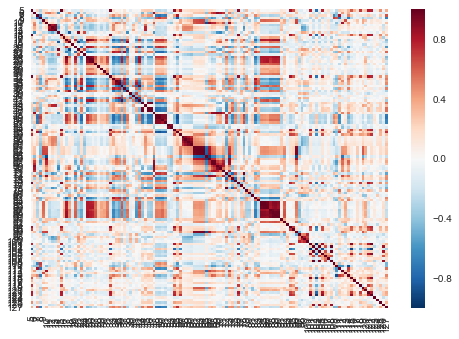

In [6]:
#pass # Place your code here
from scipy.stats.stats import pearsonr
import seaborn
values={}
clear_values=[]
#data.shape()
#data[10].head
#print(data[15])
#p_value=pearsonr(data[10], data[15])
#print(p_value)
#for d in range(10, 100):
#    print(d)
#    print(data[d])
 #   p_value=pearsonr(data[d], data[127])
  #  name=str(d)
   # values[name]=p_value
    #clear_values.append(p_value[0])
#clear_values=np.array(clear_values)
a=data[:-1].corr()
#print(a)
seaborn.heatmap(a)

Коррелирующие признаки должны портить статистику, так как они обучают регрессию так, что та принимает их корреляцию за значимую закономерность, в то время как это могут быть просто связанные переменные

#### 2. Найдите признаки у которых корреляция с предсказваемым значением максимальна и минимальна. Изобразите на графиках зависимость найденных признаков от предсказываемого значения.

признак с минимальной корреляцией: 5
признак с максимальной корреляцией: 127


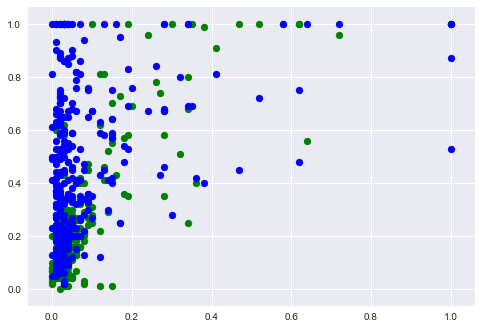

In [8]:
#minimal=min(clear_values)
#maximal=max(clear_values)
#print(minimal, maximal)
#print(a)
max_a=max(a)
min_a=min(a)
#print(min_a, max_a)
print('признак с минимальной корреляцией: '+str(min_a))
print('признак с максимальной корреляцией: '+str(max_a))
#print(data.shape)
#plt.plot(range(1, 124), a)
plt.scatter(data[122], data[min_a], color='green')
plt.scatter(data[122], data[max_a], color='blue')
#LR=lm.LinearRegression()
#LR.fit(data[122], data[min_a])
#min_pred=LR.predict(data[122])
#print(data[min_a]/data[122])
k=data[min_a]/data[122]
k1=k.fillna(value=0)
#print(len([d for d in data[122]]))
#print(k)
k2=k.dropna()
#print(k2)
k3=data[max_a]/data[122]
k3=k3.dropna()
##plt.scatter([d for d in k2], k2, color='lime', marker='^')
#LR.fit(data[122], data[max_a])
#max_pred=LR.predict(data[122])
##plt.scatter([d for d in k3], k3, color='cornflowerblue', marker='v')
#analyze=np.vstack([data[min_a], data[max_a], data[122]])
#print(analyze.shape)
#seaborn.heatmap(analyze)
#pass # Place your code here

#### 3. Постройте гистограмму распределения предсказываемого значения.

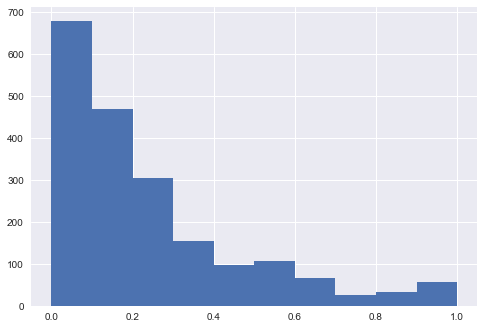

In [9]:
#pass # Place your code here
#print(a)
#a_new=a.iloc[:,1]
#a_new2=a_new.reshape(1, len(a_new))
#print(a_new)
#print(len(a_new))
#print(len(range(1, 124)))
#print(a_new2)
#plt.plot(range(1, 124), a_new2[0])
data[127].hist()

Как видно из заголовка датасета, в нём присутствует много пропущенных значений. Рассмотренные нами алгоритмы регрессии не содержат в себе методов обработки пропущенных значений, поэтому нам нужно избавиться от них на этапе предобработки данных.


#### 4. Замените все пропущенные значения на средние по соответствующим признакам. Сохраните результат в переменную data.

In [10]:
#pass # Place your code here
#data.head
#print(data.mean())
#data.count('NaN')
data.fillna(value=data.mean())
#data.head()
#print(data)
#print('a')

,5,6,7,8,9,10,11,12,13,14,...,118,119,120,121,122,123,124,125,126,127
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.03
5,0.02,0.28,0.06,0.54,1.00,0.25,0.31,0.48,0.27,0.37,...,0.01,0.58,0.10,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.14
6,0.01,0.39,0.00,0.98,0.06,0.02,0.30,0.37,0.23,0.60,...,0.05,0.08,0.06,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.03
7,0.01,0.74,0.03,0.46,0.20,1.00,0.52,0.55,0.36,0.35,...,0.01,0.33,0.00,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.55
8,0.03,0.34,0.20,0.84,0.02,0.00,0.38,0.45,0.28,0.48,...,0.04,0.17,0.04,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.53
9,0.01,0.40,0.06,0.87,0.30,0.03,0.90,0.82,0.80,0.39,...,0.00,0.47,0.11,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.15


Разделим данные на три выборки: по одной мы будем обучать регрессию, по второй -- гиперпараметры, по третьей -- тестировать качество:

In [11]:
data1=data.fillna(value=data.mean())
data1.head()
data1 = data1.reindex(np.random.permutation(data1.index))
data_train, data_validate, data_test = np.array_split(data1, 3)

Учтём, что целевая переменная -- это последний столбец данных:

In [12]:
X_train = data_train.iloc[:,:-1]
y_train = data_train.iloc[:,-1]
X_validate = data_validate.iloc[:,:-1]
y_validate = data_validate.iloc[:,-1]
X_test = data_test.iloc[:,:-1]
y_test = data_test.iloc[:,-1]

In [13]:
X_train_new = np.concatenate([X_train, X_validate], axis=0)
y_train_new = np.concatenate([y_train, y_validate], axis=0)

#### 5. Обучите обычную линейную регрессию на выборке (X_train_new, y_train_new).  Оцените качество предсказания на данных X_test.

Качество оценивайте, как среднеквадратичное отклонения ваших предсказаний на тестовой выборке от истинных значений: $$\text{err}\ (y^{pred}, y^{test}) = \frac{1}{N} \sum_{n=1}^N (y^{pred}_n - y^{test}_n)^2$$

In [18]:
#pass # Place your code here
from sklearn.metrics import mean_squared_error
LR = lm.LinearRegression()
#print(X_train_new)
LR.fit(X_train_new, y_train_new)
#print(X_test)
y_pred = LR.predict(X_test)
#plt.scatter(X_test, y_test, color='yellow')
#plt.scatter(X_train_new, y_train_new)
err=mean_squared_error(y_test, y_pred)
print('среднеквадратичная ошибка: '+str(err))

среднеквадратичная ошибка: 0.0228810476658


#### 6. Используя sklearn.model_selection.GridSearchCV(), подберите оптимальные значения гиперпараметра alpha для  регрессий Ridge и Lasso

In [19]:
#pass # Place your code here
from sklearn.model_selection import GridSearchCV
from sklearn import svm, datasets
alphas=np.logspace(-10, -1, 100)
#print(alphas)
parameters=[{'alpha': alphas}]
svc = svm.SVC()
Ridge=lm.Ridge()
Lasso=lm.Lasso()
clf = GridSearchCV(Ridge, parameters)
clf.fit(X_train_new, y_train_new)
a=clf.best_estimator_
print(a)
clf1=GridSearchCV(Lasso, parameters)
clf1.fit(X_train_new, y_train_new)
b=clf1.best_estimator_
print(b)

Ridge(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)


C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to in

Lasso(alpha=0.00053366992312063122, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)


In [22]:
from sklearn.metrics import mean_squared_error
y_Ridge=a.predict(X_test)
y_Lasso=b.predict(X_test)
mse_Ridge=mean_squared_error(y_test, y_Ridge)
mse_Lasso=mean_squared_error(y_test, y_Lasso)
#print(mse_Ridge, mse_Lasso)
print('MSE для Ridge: '+str(mse_Ridge))
print('MSE для Lasso: '+str(mse_Lasso))

MSE для Ridge: 0.0219634274099
MSE для Lasso: 0.0212170144796


Рассмотрите значения полученных весов для регрессии в с лучшим alpha для Ridge и Lasso. В чём их существенная разница? Какие выводы вы можете сделать о структуре данных по регрессионным весам?

In [23]:
## https://habrahabr.ru/post/206306/
weights_Ridge=a.coef_
weights_Lasso=b.coef_
#print(weights_Ridge)
#print(weights_Lasso)
important_weights=[]
for i in range(len(weights_Lasso)):
#    print(i, weights_Lasso[i])
    if abs(weights_Lasso[i])>0.05:
        important_weights.append(i+5)
#print(important_weights)

в весах Lasso-регрессии очень много нулевых значений. Это значит, что Lasso выбирает коэффициенты, которые она считает нужными, и приравнивает к нулю остальные. Например, коэффициент афроамериканского населения (индекс 7) Lasso находит нужным, а коэффициент населения испаноязычных граждан (индекс 10) - нет.

Исходя из весов регрессии Lasso, отберите наиболее релевантные признаки и обучите две лучшие регрессионные модели только на них. Насколько сильно при этом изменилась средняя ошибка? Что это говорит о структуре данных? 

In [24]:
#pass # Place your code here
print(important_weights)
#data1.head()
needed_data=data1.loc[:,important_weights]
#print(needed_data)
needed_data_train, needed_data_test = np.array_split(needed_data, 2)
n_X_train = needed_data_train.iloc[:,:-1]
n_y_train = needed_data_train.iloc[:,-1]
n_X_test = needed_data_test.iloc[:,:-1]
n_y_test = needed_data_test.iloc[:,-1]
new_Ridge=clf.best_estimator_
new_Ridge.fit(n_X_train, n_y_train)
pred1=new_Ridge.predict(n_X_test)
new_Lasso=clf1.best_estimator_
new_Lasso.fit(n_X_train, n_y_train)
pred2=new_Lasso.predict(n_X_test)
print('Среднеквадратичная ошибка для Ridge: '+str(mean_squared_error(n_y_test, pred1)))
print('Среднеквадратичная ошибка для Lasso: '+str(mean_squared_error(n_y_test, pred2)))

[7, 43, 49, 50, 53, 55, 73, 76, 90, 95]
Среднеквадратичная ошибка для Ridge: 0.00687229941571
Среднеквадратичная ошибка для Lasso: 0.00685004099788


Ошибка значительно уменьшилась (со второго до третьего знака после запятой, примерно в четыре раза). Это показывает, что Lasso, скорее всего, подобрала правильные параметры для регрессии.

#### 7. Обучите KNN на выборке (X_train_new, y_train_new).  Оцените качество предсказания на данных X_test.

In [26]:
#pass # Place your code here
#from sklearn.neighbors import KNeighborsRegressor as skn
#neigh = skn.NearestNeighbors(3).fit(X_train_new)
#y_pred=neigh.predict(X_test)
#plt.plot([i for i in range(len(X_test))], y_pred)
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_train_new, y_train_new)
#print(X_train_new.shape, X_test.shape)
a=neigh.predict(X_test)
#plt.plot([i for i in range(len(X_test))], a)
#print(len(y_test), len(a))
err_value=mean_squared_error(y_test, a)
print('MSE='+str(err_value))

MSE=0.0280653990964


#### 8. Используя sklearn.model_selection.GridSearchCV(), подберите оптимальные значения параметров n_neighbors и p при выборе  metric='minkowski'

In [27]:
#pass # Place your code here
from sklearn.model_selection import GridSearchCV
from sklearn import svm, datasets
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(metric='minkowski')
num_n_neighbors=np.arange(1, 20, 1)
#print(num_n_neighbors)
power_params=[1,2,3]
parameters=[{'n_neighbors':num_n_neighbors, 'p':power_params}]
#print(X_test)
#svc = svm.SVC()
clf = GridSearchCV(neigh, parameters)
clf.fit(X_train_new, y_train_new)
knn_best=clf.best_estimator_
print(knn_best)
#clf.fit(X_test, a)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=9, p=1,
          weights='uniform')


In [29]:
knn_best.fit(X_train_new, y_train_new)
best_test=knn_best.predict(X_test)
best_error_value=mean_squared_error(y_test, best_test)
print('MSE: '+str(best_error_value))

MSE: 0.0236689015321


С помощью какого алгоритма удалось достичь лучшего качества?

Исходя из показателя среднеквадратичной ошибки, лучше всего выбрать Lasso-регрессию с параметром alpha, близким к 0.0005 (в примере alpha=0.00053366992312063122)

Напишите отчёт по исследованному вами датасету. Какими он обладает ключевыми свойствами? Какие методы вам пришлось использовать, чтобы его исследовать? Что вы можете сказать об информативности используемых в нём признаков? Какой из опробованных методов вы бы предпочли использовать на нём и почему?

датасет состоит полностью (кроме первых пяти столбцов) из вещественных признаков, значит, к нему можно применять модели регрессии без предварительной подготовки данных. 

Для его исследования необходимо было использовать различные модели линейных регрессий и попарную корелляцию Пирсона.
Информативность признаков не очень высока, так как неизвестно, каким образом высчитывались коэффициенты, находящиеся в датасете. Кроме того, некоторые признаки являются достаточно сильно коррелирующими, в чем можно убедиться как из визуализации, так и из описания датасета, например, процентные соотношения полицейских и населения в целом по расам (которые должны в сумме давать единицу), а также процент детей, растущих в полных семьях, и детей, рожденных в семьях одиночек.

Исходя из значения среднеквадратичного отклонения, я бы использовал либо регрессор kNN с количеством соседей, равным 19, либо Lasso-регрессию с alpha, близким к 0.0005

### Бонусная часть

За выполнение указанного ниже задания вам могут быть начислены дополнительные баллы свыше максимальных 10.

##### Реализуйте свмостоятельно функцию, которая будет перебирать значения гиперпараметра по линейной сетке 

Процесс обучения модели будет состоять из двух этапов.

Сначала для каждого значения гиперпараметра из заранее заданной сетки мы обучим регрессию на выборке (X_train, y_train) и проверим качество её работы на выборке (X_validate, y_validate). Сохранив полученные значения, среди всех перебранных значений гиперпараметра выберем такое, на котором достигается наименьшая ошибка на выборке (X_validate, y_validate).

После этого мы фиксируем значение гиперпараметра, и обучаем итоговый алгоритм на выборке, полученной объединением из X_train и X_validate . Тем самым мы сможем добиться лучшей настройки параметров регресси.

В конце концов, для тестирования качества работы нашей модели, мы проверяем её на тестовой выборке (X_test, y_test). Ошибка на этой выборке позволяет нам судить об обобщающей способности нашей модели, т.к. она не участвовала ни в одном этапе обучения. Обобщающая способность -- оценка того, насколько хорошо модель регрессии будет работать на новых данных.

In [ ]:
def optimizer(X_train, y_train, X_validate, y_validate, 
              alpha_min, alpha_max, RegressionClass):
    alpha_grid = np.linspace(alpha_min, alpha_max, 100)
    
    #alpha_grid - массив перебираемых значений гиперпараметра
    #alpha - найденное оптимальное значение гиперпараметра 
    #err - массив среднеквадратичных отклонений для каждого из alpha_grid
    
    return alpha, err, alpha_grid

Пример вызова:
        
        alpha, err, alpha_grid = optimiser(X_train, y_train, 
                                           X_validate, y_validate,
                                           alpha_min, alpha_max,
                                           lm.Ridge)

От вас требуется применить линейную регрессию, а также Ridge и Lasso регрессию, получив оптимальные значения для alpha при помощи функции optimizer, и сравнить полученные среднеквадратичные отклонения ваших предсказаний на тестовой выборке от истинных значений: $$\text{err}\ (y^{pred}, y^{test}) = \frac{1}{N} \sum_{n=1}^N (y^{pred}_n - y^{test}_n)^2$$

Для того чтобы понять, какие значения alpha для регрессий Ridge и Lasso являются оптимальными, вам нужно подобрать параметры alpha_min и alpha_max так, чтобы на графиках зависимости ошибки err от alpha был виден отчётливый минимум. Код для построения графиков указан ниже.

Обучите регрессии на выборке (X_train_new, y_train_new)
Какая из трёх регрессий работает лучше? Какая хуже? Почему?

Сделайте вызов функции optimizer для Ridge регрессии на выборках (X_train, y_train), (X_validate, y_validate), воспользовавшись примером её запуска. Получите оптимальное alpha, подобрав параметры alpha_min, alpha_max, как указано в задании. Обучите регрессию на выборке (X_train_new, y_train_new) с полученным параметром alpha, который передаётся при инициализации класса, например:

    lm.Ridge(alpha=my_alpha)
    
и сохраните ответы на тестовой выборке X_test в переменную y_pred

In [ ]:
pass # Place your code here

print(np.mean((y_pred - y_test)**2))
print(data.mean()[-1])

Код для построения графиков ошибки на валидационной выборке в зависимости от alpha:

In [ ]:
plt.plot(alpha_grid, err)
plt.show()

Аналогично части задания для регресии Ridge, сделайте вызов функции optimizer для регрессии Lasso, обучите её с оптимальным alpha на выборке (X_train_new, y_train_new) и сохраните предсказания для X_test в y_pred

In [ ]:
pass # Place your code here

print(np.mean((y_pred - y_test)**2))
print(data.mean()[-1])

In [ ]:
plt.plot(alpha_grid, err)
plt.show()

#### Бонусная часть 2

Ещё одним способом построения новых признаков по выборке (помимо полиномиальных преобразований) являются так называемые приближения ядер RBF (Radial Basis Function Kernel Approximations). Данный метод используется широко и везде, так как позволяет проводить в данных регрессионные кривые, вообще говоря, практически произвольной сложности. Суть его заключается в том, что он производит некоторое нелинейное преобразование признаков, которое призвано приближать абстрактное пространство бесконечной размерности. Если размерность пространства бесконечна, то в нём можно посредством линейной регрессии провести произвольную разделяющую поверхность -- в этом суть мощности данного метода.

У метода существуют два настраиваемых параметра: gamma и n_components. Для объяснения значения первого параметра потребуется подключать достаточно сложную линейную алгебру или привлекать понятие ядровой функции, что мы делать сейчас не будем. Смысл второго параметра -- количество получаемых признаков. Т.к. пространство, которое мы пытаемся приблизить, бесконечной размерности, то, вообще говоря, в n_components можно поставить любое число. Чем больше оно будет, тем лучше наши новые данные будут приближать абстрактное пространство. Данные параметры в любом случае следует лишь перебирать по сетке и выбирать те, на которых меньше всего ошибка. Для того чтобы перебор не оказался слишком большим, положим n_components равным размеру выборки, и будем настраивать лишь gamma. В предложенной задаче это не критично.

Ниже приведён код, который уже знакомым вам по функции optimizer образом переберёт по сетке гиперпараметры используемых методов: параметр gamma для RBF, и параметр alpha для Ridge регрессии. Перебор будем осуществлять по всем возможным комбинациям gamma и alpha, выбрав комбинацию с наименьшей ошибкой на валидационной выборке. Обратите внимание, что обучаться мы будем именно по подвыборке признаков, полученных вами в предыдущем задании, т.е. исключая из данных большую часть данных. Интересно, что из этого выйдет?

In [ ]:
from sklearn import kernel_approximation as ka

alpha_grid = np.linspace(0.001, 1, 10)
gamma_grid = np.linspace(0.001, 1, 10)

min_err = +np.inf
for alpha in alpha_grid:
    for gamma in gamma_grid:
        RBF = ka.RBFSampler(gamma=gamma, n_components=X_train.shape[0])
        X_train_rbf = RBF.fit_transform(X_train_shrinked)
        X_validate_rbf = RBF.transform(X_validate_shrinked)
        Ridge = lm.Ridge(alpha=alpha)
        Ridge.fit(X_train_rbf, y_train)
        y_pred = Ridge.predict(X_validate_rbf)
        err = np.mean((y_pred - y_validate)**2)
        if err < min_err:
            min_err = err
            alpha_best = alpha
            gamma_best = gamma

Выполнив код выше, вы получили две переменные alpha_best и gamma_best с оптимальными значениями гиперпараметров. От вас потребуется обучить на выборке (X_train_new_shrinked, y_train_new) преобразование RBF с параметром gamma_best (параметр n_components заполните так, как указано в примере ниже), а потом обучить на полученных признаках Ridge регрессию с полученным alpha_best и сравнить получившуюся ошибку с ошибой всех предыдущих методов. Какой эффект вы заметили?

Для обучения преобразования RBF вам потребуется сначала преобразовать обучающую выборку с помощью метода fit_transform (в вашем случае X_train_new_shrinked), а потом применить обученное преобразование к тестовой выборке (X_test_shrinked)

    RBF = ka.RBFSampler(gamma=gamma_best, n_components=X_train_new.shape[0])
    X_train = RBF.fit_transform(X_train)
    X_test = RBF.transform(X_test)

Ниже запишите вызов класса RBF, получите новые признаки для обучающей и тестовой выборки. Постройте Ridge регрессию по выборке (X_train_new_shrinked, y_train_new), найде предсказания для тестовой X_test_shrinked, поместите их в переменную y_pred.

In [ ]:
pass # Place your code here

print(np.mean((y_pred - y_test)**2))
print(data.mean()[-1])